# Importing Libraries

Now for modelling, the package we need is `Juliet` and the same can be called by using `import juliet`. `numpy` and `matplotlib` are already discussed in the previous section. `sympy` is a python library for symbolic mathematics. `tabulate` is to setup the final list of calculated parameters

In [1]:
import juliet
import numpy as np
import matplotlib.pyplot as plt
from sympy import *
from numpy import *
import os
import sys
from tabulate import tabulate
import corner

font1 = {'family':'serif','color':'black'}

C:\Users\computer\anaconda3\lib\site-packages\autograd\numpy\numpy_wrapper.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  int_types = {_np.int, _np.int8, _np.int16, _np.int32, _np.int64, _np.integer}


problem: Could not find module 'libmultinest.dll' (or one of its dependencies). Try using the full path with constructor syntax.


# Define Priors

The Juliet model works based on the nested sampling which in general uses the Bayesian statistics (already discussed above). so to model the light curve to the data we must have to provide some prior values.

To get the knowladge about different priors and how it works visit the following website :

https://juliet.readthedocs.io/en/latest/user/priorsnparameters.html

In [11]:
filename = 'Detrended & Combined Lightcurves/Combined_TOI_1148.fits' # Transit Data File
rv_datafile = 'Transit & RV Data/TOI_1148_RV.dat'                    # RV Data File
output_folder = 'TOI_1148_Global_Fit'                                # Folder in which Results will be saved

# Name of Target Star
Target_Star = 'TOI 1148'

# ---------------------------------------------------------------------------------------------------------

# Priors for different Parameters 
Period, Period_Deviation = [5.5514, 0.00009]           # Normal Distribution
Time, Time_Deviation = [2457000 + 1684.8164, 0.0002]   # Normal Distribution

# r1 & r2 are Parametrization of Espinoza (2018) for Rp/Rs and Impact Parameter
# uniform distribution : Suggested to fit in between [0, 1]

# q1 & q2 are LD Parametrization of Kipping for two parameter LD Laws except logarithmic Law 
# uniform distribution : Suggested to fit in between [0, 1]

a, a_Deviation = [9.95,0.17]                           # Normal distribution
K_lower, K_upper = [0, 500]                            # Uniform distribution
mu_lower, mu_upper = [0, 500]                          # Uniform distribution
e_lower, e_upper = [0, 0.5]                            # Uniform distribution
w_lower, w_upper = [0, 90]                             # Uniform distribution

instrument_rv = 'TRES' # Instrument being used to collect RV Data
instruments = ['TRES'] # List of Instruments used to collect RV data
# ---------------------------------------------------------------------------------------------------------


# Define the master prior dictionary. First define the TRANSIT priors
priors = {}

# Name of the parameters to be fit:
params = ['P_p1', 't0_p1', 'r1_p1', 'r2_p1', 'q1_TESS', 'q2_TESS', 'a_p1', 'mdilution_TESS', 'mflux_TESS', 'sigma_w_TESS', \
         'K_p1', 'mu_'+instrument_rv, 'ecc_p1', 'omega_p1', 'sigma_w_'+instrument_rv]

# Distribution for each of the parameters:
dists = ['normal', 'normal', 'uniform', 'uniform', 'uniform', 'uniform', 'uniform', 'fixed', 'normal', 'loguniform', \
         'uniform', 'uniform', 'uniform', 'uniform', 'loguniform']


hyperps = [[Period, Period_Deviation], [Time, Time_Deviation], [0, 1], [0, 1], [0, 1], [0, 1],\
           [a, a_Deviation], 1.0, [0,0.1], [0.1, 1000], \
           [K_lower, K_upper], [mu_lower, mu_upper], [e_lower, e_upper], [w_lower, w_upper], [1, 10]]

# Populate the priors dictionary:
for param, dist, hyperp in zip(params, dists, hyperps):
    priors[param] = {}
    priors[param]['distribution'], priors[param]['hyperparameters'] = dist, hyperp

This is how the priors.dat file looks like

| Prior        | Distribution           | Value  |
| ------------- |:-------------:| -----:|
|P_p1               |  normal         |      5.5514,9e-05        |
|t0_p1              |  normal         |      2458684.8164,0.0002 |
|r1_p1              |  uniform        |      0,1                 |
|r2_p1              |  uniform        |      0,1                 |
|q1_TESS            |  uniform        |      0,1                 |
|q2_TESS            |  uniform        |      0,1                 |
|a_p1               |  uniform        |      9.95,0.17           |
|mdilution_TESS     |  fixed          |      1.0                 |
|mflux_TESS         |  normal         |      0.0,0.1             |
|sigma_w_TESS       |  loguniform     |      0.1,1000.0          |
|K_p1               |  uniform        |      0,500               |
|mu_TRES            |  uniform        |      0,500               |
|ecc_p1             |  uniform        |      0.0,0.5             |
|omega_p1           |  uniform        |      0,90                |
|sigma_w_TRES       |  loguniform     |      1,10                |

# Data Fitting (Transit + RV)

For this data fitting process we need to load the data files and prior files using the code `juliet.load` along with the path to the output folder to which the results will be stored. The data fitting process can be initiated by the code `juliet.fit` in which we need to provide some fitting parameters discussed on the website of Juliet Documentation, the link for the same is given below.

https://juliet.readthedocs.io/en/latest/user/api.html

In [10]:
# First get TESS photometric data
t, f, ferr = juliet.get_TESS_data(filename)

# Put data in dictionaries, add 2457000 to the times to convert from TESS JD to JD:
times, fluxes, fluxes_error = {}, {}, {}
times['TESS'], fluxes['TESS'], fluxes_error['TESS'] = t + 2457000, f, ferr

# RV data is given in a file, so let's just pass the filename to juliet and load the dataset:
dataset = juliet.load(priors = priors, t_lc = times, y_lc = fluxes, \
                      yerr_lc = fluxes_error, rvfilename = rv_datafile, \
                      out_folder = output_folder)

# And now let's fit it!
results = dataset.fit(sampler = 'dynesty', n_live_points = 500, nwalkers = 100000, nsteps = 300000, nburnin = 500000, \
                      emcee_factor = 0.0001, ecclim = 1.0, pl = 0.0, pu = 1.0, ta = 2457000.0, \
                      nthreads = None, dynamic = True, \
                      dynesty_bound = 'multi', dynesty_sample = 'rwalk', dynesty_nthreads = None, \
                      dynesty_n_effective = np.inf, dynesty_use_stop = True, dynesty_use_pool = None)

Detected dynesty sampler output files --- extracting from TOI_1148_Global_Fit/_dynesty_NS_posteriors.pkl


# Transit Lightcurve

The above section will take some time to fit the data and will store the results to the given location in a file titled `_dynesty_NS_posteriors.pkl`. This file is not in human readable format. The calculated parameters from the previously mentioned file are stored into the file titled `posteriors.dat`. Now to plot the transit light curve model fitted to the data can be done by the following code. Now we call the model parameters from the results.lc file and from the evaluated parameters we define the phases to period fold the light curve. This process is done below in the section entitled "Evaluating the Model". The plotting part is initiated into the further section having a title "Plotting the Model & Data".

### 1. Evaluating the Model

In [12]:
transit_model = results.lc.evaluate('TESS') # Evaluating the model

# ------------------------------------------------------------------------------------------
# Extract period and time of transit center for the planet
# ------------------------------------------------------------------------------------------
P, t0 = np.median(results.posteriors['posterior_samples']['P_p1']),\
        np.median(results.posteriors['posterior_samples']['t0_p1'])

# ------------------------------------------------------------------------------------------
# Define plot, get phases, plot data and best-fit model
# ------------------------------------------------------------------------------------------
phases0 = juliet.get_phases(dataset.times_lc['TESS'], P, t0) 
idx0 = np.argsort(phases0)
p_bin, y_bin, yerr_bin = juliet.bin_data(phases0[idx0], dataset.data_lc['TESS'][idx0], 100) # Data binning

### 2. Plotting the Model & Data

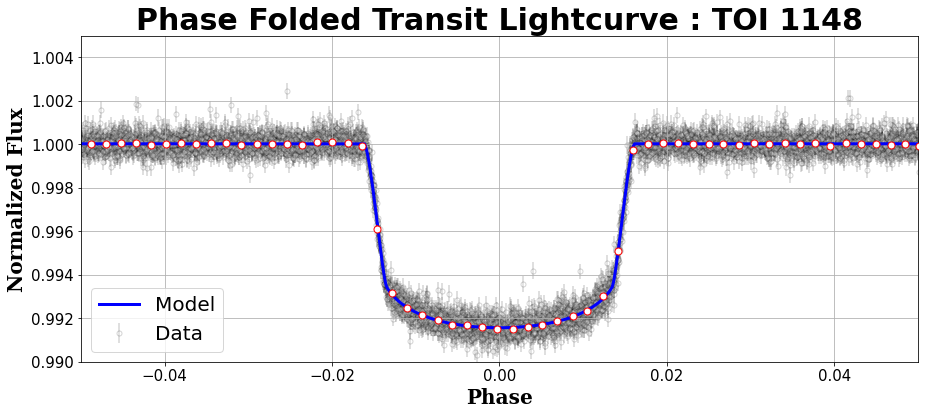

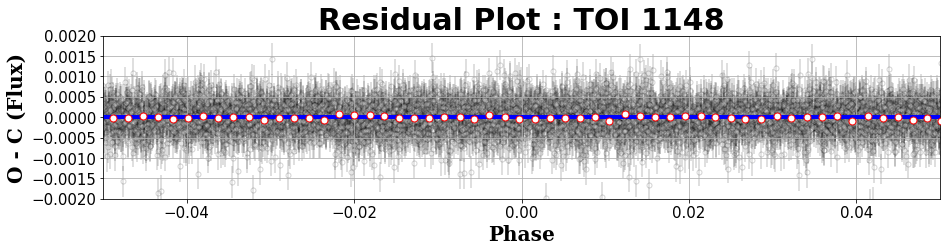

In [5]:
# ------------------------------------------------------------------------------------------
# Plotting the Graph
# ------------------------------------------------------------------------------------------
plt.figure()

plt.errorbar(phases0, dataset.data_lc['TESS'], yerr= dataset.errors_lc['TESS'],\
             fmt='ko', mfc = 'white',markersize=5, alpha = 0.17, zorder = 1) # Plot whole data set in background

plt.plot(phases0[idx0],transit_model[idx0], color='b', lw = 3, zorder = 2) # Plot the model 

plt.errorbar(p_bin, y_bin, yerr = yerr_bin, fmt='ro', mfc = 'white',markersize=7, zorder = 3) # Plot the binned data for reference


# ------------------------------------------------------------------------------------------
# Graph Designs
# ------------------------------------------------------------------------------------------
plt.title("Phase Folded Transit Lightcurve : %s" %(Target_Star), weight = "bold",fontsize="30")
plt.xlabel('Phase',fontdict=font1, weight = "bold",fontsize="20")
plt.ylabel('Normalized Flux',fontdict=font1, weight = "bold",fontsize="20")

plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(["Model", "Data"], prop={'size': 20})
plt.grid()

fig=plt.gcf()
fig.set_size_inches(15,6)

plt.xlim([-0.05, 0.05])
plt.ylim([0.990, 1.0050])

# Save figure to output folder
fig.savefig(os.path.join(output_folder, Target_Star+' Transit.jpeg'), format='jpeg', dpi=1200)

# Residual Plot
plt.figure()

p_bin1, y_bin1, yerr_bin1 = juliet.bin_data(phases0[idx0], dataset.data_lc['TESS'][idx0] - transit_model[idx0], 100) # Data binning

plt.errorbar(phases0, transit_model - dataset.data_lc['TESS'], yerr= dataset.errors_lc['TESS'],\
             fmt='ko', mfc = 'white',markersize=5, alpha = 0.17, zorder = 1)

plt.plot(phases0, np.zeros(np.size(phases0)), color='b', lw = 3, zorder = 2)

plt.errorbar(p_bin1, y_bin1, yerr = yerr_bin1, fmt='ro', mfc = 'white',markersize=7, zorder = 3)

plt.title("Residual Plot : %s" %(Target_Star), weight = "bold",fontsize="30")
plt.xlabel('Phase',fontdict=font1, weight = "bold",fontsize="20")
plt.ylabel('O - C (Flux)',fontdict=font1, weight = "bold",fontsize="20")

plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.grid()

fig=plt.gcf()
fig.set_size_inches(15,3)

plt.xlim([-0.05, 0.05])
plt.ylim([-0.002, 0.002])

# Save figure to output folder
fig.savefig(os.path.join(output_folder, Target_Star+' Transit Residual.jpeg'), format='jpeg', dpi=1200)

This how the Transit light curve looks like. The gray points you can see in the background are the data points along with the errorbars. Blue line is the fitted model, and the red dots are the binned data using which we can easily observe how the model is fitted to the data. Below is shown the Residual Plot from which we can observe how model is fitted to the data

# Radial Velocity Lightcurve

Same things as we did for the transit light curve need to be done to plot the radial velocity curve. minimum time and maximum time can be identified from the data and accordingly phases are defined.

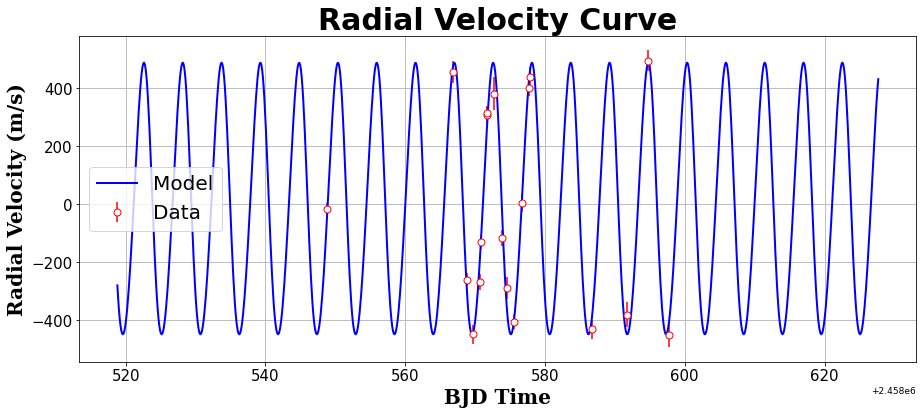

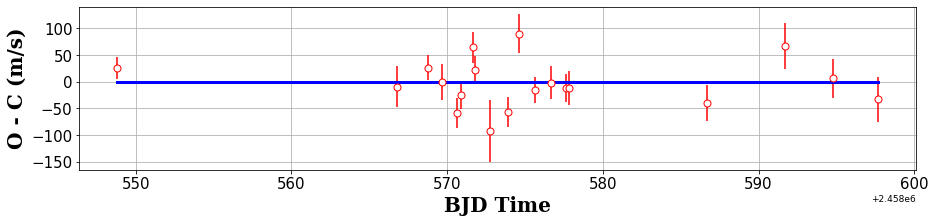

In [6]:
# ---------------------------------------------------------------------------------
# Define time staps
# ---------------------------------------------------------------------------------
min_time, max_time = np.min(dataset.times_rv[instrument_rv])-30,\
                            np.max(dataset.times_rv[instrument_rv])+30  # Max & Min Time

model_rv_times = np.linspace(min_time, max_time,1000) # Time Steps


# ---------------------------------------------------------------------------------
# Evaluate RV Model (Use all the posterior samples, also extract model components)
# ---------------------------------------------------------------------------------
rv_model, components = results.rv.evaluate(instrument_rv, t = model_rv_times, all_samples = True, \
                                           return_components = True)

rv_model -= components['mu'] # Subtract the mean term to normalize the LC


# ---------------------------------------------------------------------------------
# Iterate through the instruments 
# Evaluate a model at those times
# ---------------------------------------------------------------------------------

# Radial Velocity Curve
plt.figure()
for i in range(len(instruments)):
    
    instrument = instruments[i]
    
    # Evaluate jitter level (will be added in quadrature to data errors)
    jitter = np.median(results.posteriors['posterior_samples']['sigma_w_'+instrument])
    
    # Plot data with the (full model - planet 1) substracted, so we see the Keplerian of planet
    # 1 imprinted on the data. For this, evaluate model in the data-times first
    c_model, c_components = results.rv.evaluate(instrument, t = dataset.times_rv[instrument], \
                                                all_samples = True, return_components = True)
    
    # Now plot RV data with (best model - planet component) substracted:
    plt.errorbar(dataset.times_rv[instrument_rv], dataset.data_rv[instrument]- (c_model - c_components['p1']),\
                 yerr = np.sqrt(dataset.errors_rv[instrument]**2+jitter**2), fmt='ro', mfc = 'white',markersize=7)


plt.plot(model_rv_times, rv_model, color='b', lw = 2)

plt.title("Radial Velocity Curve", weight = "bold",fontsize="30")
plt.xlabel('BJD Time',fontdict=font1, weight = "bold",fontsize="20")
plt.ylabel('Radial Velocity (m/s)',fontdict=font1, weight = "bold",fontsize="20")

plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(["Model", "Data"], prop={'size': 20})
plt.grid()

fig=plt.gcf()
fig.set_size_inches(15,6)

# Save figure to output folder
fig.savefig(os.path.join(output_folder, Target_Star+' RV.jpeg'), format='jpeg', dpi=1200)


#----------------------------------------------------------------------------------------
# Residual Plot
#----------------------------------------------------------------------------------------

rv_model_at_obs_time, components = results.rv.evaluate(instrument_rv, t = dataset.times_rv[instrument_rv], all_samples = True, \
                                           return_components = True)

rv_model_at_obs_time -= components['mu'] # Subtract the mean term to normalize the LC

plt.figure()
for i in range(len(instruments)):
    
    instrument = instruments[i]
    
    # Evaluate jitter level (will be added in quadrature to data errors)
    jitter = np.median(results.posteriors['posterior_samples']['sigma_w_'+instrument])
    
    # Plot data with the (full model - planet 1) substracted, so we see the Keplerian of planet
    # 1 imprinted on the data. For this, evaluate model in the data-times first
    c_model, c_components = results.rv.evaluate(instrument, t = dataset.times_rv[instrument], \
                                                all_samples = True, return_components = True)
    
    # Now plot RV data with (best model - planet component) substracted:
    plt.errorbar(dataset.times_rv[instrument_rv], (dataset.data_rv[instrument]- (c_model - c_components['p1'])) - rv_model_at_obs_time,\
                 yerr = np.sqrt(dataset.errors_rv[instrument]**2+jitter**2), fmt='ro', mfc = 'white',markersize=7)

plt.plot(dataset.times_rv[instrument_rv], np.zeros(np.size(dataset.times_rv[instrument_rv])), color='b', lw = 3, zorder = 2)
    
plt.xlabel('BJD Time',fontdict=font1, weight = "bold",fontsize="20")
plt.ylabel('O - C (m/s)',fontdict=font1, weight = "bold",fontsize="20")

plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.grid()

fig=plt.gcf()
fig.set_size_inches(15,3)

# Save figure to output folder
fig.savefig(os.path.join(output_folder, Target_Star+' RV Residual.jpeg'), format='jpeg', dpi=1200)

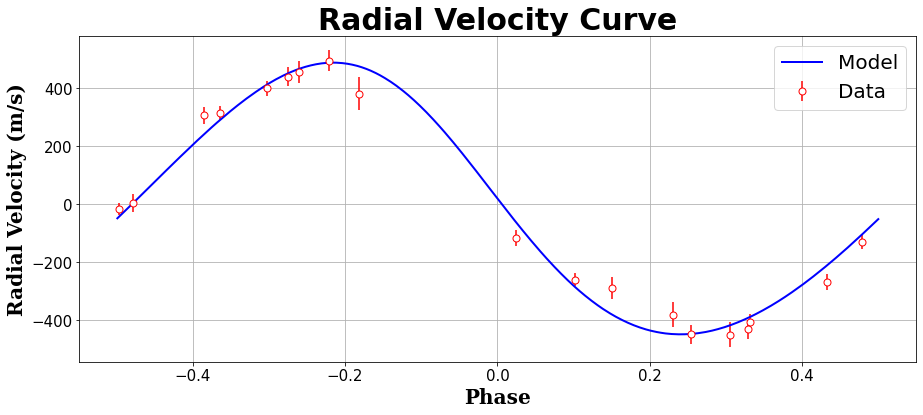

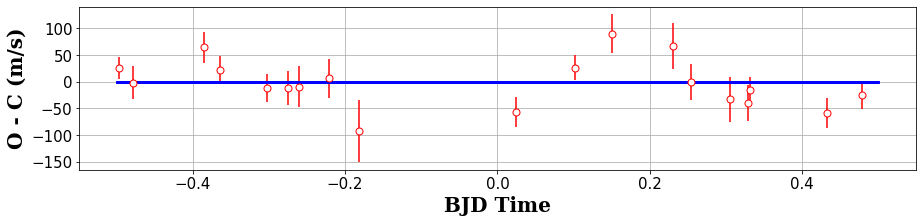

In [7]:
# ---------------------------------------------------------------------------------
# Define time staps
# ---------------------------------------------------------------------------------
min_time, max_time = np.min(dataset.times_rv[instrument_rv])-30,\
                            np.max(dataset.times_rv[instrument_rv])+30  # Max & Min Time

model_rv_times = np.linspace(min_time, max_time,1000) # Time Steps


# ---------------------------------------------------------------------------------
# Evaluate RV Model (Use all the posterior samples, also extract model components)
# ---------------------------------------------------------------------------------
rv_model, components = results.rv.evaluate(instrument_rv, t = model_rv_times, all_samples = True, \
                                           return_components = True)

rv_model -= components['mu'] # Subtract the mean term to normalize the LC


# ---------------------------------------------------------------------------------
# Iterate through the instruments 
# Evaluate a model at those times
# ---------------------------------------------------------------------------------


for i in range(len(instruments)):
    
    instrument = instruments[i]
    
    # Evaluate jitter level (will be added in quadrature to data errors)
    jitter = np.median(results.posteriors['posterior_samples']['sigma_w_'+instrument])
    
    # Get phases
    phases = juliet.get_phases(dataset.times_rv[instrument], P, t0)
    
    # Plot data with the (full model - planet 1) substracted, so we see the Keplerian of planet
    # 1 imprinted on the data. For this, evaluate model in the data-times first
    c_model, c_components = results.rv.evaluate(instrument, t = dataset.times_rv[instrument], \
                                                all_samples = True, return_components = True)
    
    # Now plot RV data with (best model - planet component) substracted:
    plt.errorbar(phases, dataset.data_rv[instrument]- (c_model - c_components['p1']),\
                 yerr = np.sqrt(dataset.errors_rv[instrument]**2+jitter**2), fmt='ro', mfc = 'white',markersize=7)


# ------------------------------------------------------------------------------------------------
# Define plot, get phases, plot data and best-fit model
# ------------------------------------------------------------------------------------------------
phases = juliet.get_phases(model_rv_times, P, t0)
idx = np.argsort(phases)


# ------------------------------------------------------------------------------------------
# Plotting the Model on the Data
# ------------------------------------------------------------------------------------------
plt.plot(phases[idx], components['p1'][idx], color='b', lw = 2)


plt.title("Radial Velocity Curve", weight = "bold",fontsize="30")
plt.xlabel('Phase',fontdict=font1, weight = "bold",fontsize="20")
plt.ylabel('Radial Velocity (m/s)',fontdict=font1, weight = "bold",fontsize="20")

plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(["Model", "Data"], prop={'size': 20})
plt.grid()

fig=plt.gcf()
fig.set_size_inches(15,6)

# Save figure to output folder
fig.savefig(os.path.join(output_folder, Target_Star+' RV Phase Folded.jpeg'), format='jpeg', dpi=1200)


#----------------------------------------------------------------------------------------
# Residual Plot
#----------------------------------------------------------------------------------------

rv_model_residual, components = results.rv.evaluate(instrument_rv, t = dataset.times_rv[instrument_rv], all_samples = True, \
                                           return_components = True)

rv_model_residual -= components['mu'] # Subtract the mean term to normalize the LC


# ---------------------------------------------------------------------------------
# Iterate through the instruments 
# Evaluate a model at those times
# ---------------------------------------------------------------------------------

plt.figure()
for i in range(len(instruments)):
    
    instrument = instruments[i]
    
    # Evaluate jitter level (will be added in quadrature to data errors)
    jitter = np.median(results.posteriors['posterior_samples']['sigma_w_'+instrument])
    
    # Get phases
    phases = juliet.get_phases(dataset.times_rv[instrument], P, t0)
    
    # Plot data with the (full model - planet 1) substracted, so we see the Keplerian of planet
    # 1 imprinted on the data. For this, evaluate model in the data-times first
    c_model, c_components = results.rv.evaluate(instrument, t = dataset.times_rv[instrument], \
                                                all_samples = True, return_components = True)
    
    # Now plot RV data with (best model - planet component) substracted:
    plt.errorbar(phases, (dataset.data_rv[instrument]- (c_model - c_components['p1'])) - rv_model_residual,\
                 yerr = np.sqrt(dataset.errors_rv[instrument]**2+jitter**2), fmt='ro', mfc = 'white',markersize=7)


# ------------------------------------------------------------------------------------------------
# Define plot, get phases, plot data and best-fit model
# ------------------------------------------------------------------------------------------------
phases = juliet.get_phases(model_rv_times, P, t0)
idx = np.argsort(phases)


# ------------------------------------------------------------------------------------------
# Plotting the Model on the Data
# ------------------------------------------------------------------------------------------
plt.plot(phases, np.zeros(np.size(phases)), color='b', lw = 3, zorder = 2)
    
plt.xlabel('BJD Time',fontdict=font1, weight = "bold",fontsize="20")
plt.ylabel('O - C (m/s)',fontdict=font1, weight = "bold",fontsize="20")

plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.grid()

fig=plt.gcf()
fig.set_size_inches(15,3)

# Save figure to output folder
fig.savefig(os.path.join(output_folder, Target_Star+' RV Phase Folded Residual.jpeg'), format='jpeg', dpi=1200)

This is how the radial velocity curve looks like. The red dots are actual data and the blue line is the model fitted to the data. The parameters estimated from the Juliet are in the folder `TOI_1148_Global_Fit`

# Output File

Now, let's see how the calculated data looks like. Below is the output file titled `posteriors.dat`. The fisrt column is name of the parameters, second column is the Median value and 3rd and 4th columns are the Upper & Lower Confidence Interval 

In [8]:
dat_file = r"TOI_1148_Global_Fit/posteriors.dat"   

with open(dat_file, 'r') as file:
    text = file.read()
    print(text)

# Parameter Name     	 	 Median       	 	 Upper 68 CI  	 	 Lower 68 CI 
P_p1               	 	 5.5514864325 	 	 0.0000030390 	 	 0.0000027567
t0_p1              	 	 2458684.8164965566 	 	 0.0000719181 	 	 0.0000776425
r1_p1              	 	 0.4483150608 	 	 0.0298051598 	 	 0.0353291262
r2_p1              	 	 0.0866357978 	 	 0.0002059741 	 	 0.0001710906
p_p1               	 	 0.0866357978 	 	 0.0002059741 	 	 0.0001710906
b_p1               	 	 0.1724725912 	 	 0.0447077397 	 	 0.0529936892
inc_p1             	 	 88.9220198584 	 	 0.3276252929 	 	 0.2694596893
q1_TESS            	 	 0.1804166190 	 	 0.0209318172 	 	 0.0209542522
q2_TESS            	 	 0.3263837549 	 	 0.0490989209 	 	 0.0408920453
a_p1               	 	 9.8975850766 	 	 0.0357540658 	 	 0.0775394120
mflux_TESS         	 	 -0.0000257114 	 	 0.0000014840 	 	 0.0000015963
sigma_w_TESS       	 	 125.8377841654 	 	 3.3729502022 	 	 3.6822850520
K_p1               	 	 468.5249154369 	 	 9.9982431058 	 	 9.9517829613
mu_TRE

# Calculation of Planetary Parameters

Based on the given parameters above we can calculate other useful planetary parameters such as Transit Depth, Planetary Radius, Planetary Mass, Density and so on. That can be done ussing the following simple calculations.

## 1. Constants & Conversions

Befor doing the calculations let's first define the required constants listed below.

In [2]:
# ----------------------------------------------------------------------------------------------
# Define Constants
# ----------------------------------------------------------------------------------------------

PI = np.pi                 # pi
G = 6.67*10**(-11)         # Gravitational Constant
AU = 1.496*10**(11)        # Astronomical Unit
M_S = 1.989*10**(30)       # Solar Mass
M_J = 1.898*10**(27)       # Jupiter Mass
M_E = 5.97219*10**(24)     # Earth Mass

R_S = 6.9634*10**(8)       # Solar Radius
R_J = 6.9911*10**(7)       # Jupiter Radius
R_E = 6371000              # Earth Radius

# Conversions
d2s = 24*3600              # Days to Seconds (for orbital period)
d2r = PI/180               # Degree to Radian (for inclination angle and Argument of Periastron)

## 2. Stellar & Planetary Parameters obtained from the Juliet Run

This parameters are needed to input by the user. 

In [3]:
# -------------------------------------------------
# Some User inputs !!
# -------------------------------------------------
mass_of_the_host_star_in_solar_masses = 1.46
radius_of_the_host_star_in_solar_radius = 1.506
temperature_of_the_host_star = 6509


# -------------------------------------------------
m1 = mass_of_the_host_star_in_solar_masses*M_S
r1 = radius_of_the_host_star_in_solar_radius*R_S
T1 = temperature_of_the_host_star


P, Pu, Pl = [5.5514864325*d2s, 0.0000030390*d2s, 0.0000027567*d2s]                # Orbital Period

t0, t0u, t0l = [2458684.8164965566, 0.0000719181, 0.0000776425]                   # Epoch Time

rprs, rprsu, rprsl = [0.0866357978, 0.0002059741, 0.0001710906]                   # Fractional Radius

b, bu, bl = [0.1724725912, 0.0447077397, 0.0529936892]                            # Impact Parameter

i, iu, il = [88.9220198584*d2r, 0.3276252929*d2r, 0.2694596893*d2r]               # Inclination Angle

ars, arsu, arsl = [9.8975850766, 0.0357540658, 0.0775394120]                      # Orbital Semi-major Axis

K, Ku, Kl = [468.5249154369, 9.9982431058, 9.9517829613]                          # RV Semi-amplitude

ecc, eccu, eccl = [0.0815949662, 0.0101701128, 0.0101247829]                      # Eccentricity

omega, omegau, omegal = [57.3097793972*d2r, 6.2119029169*d2r, 6.0869701611*d2r]   # Argument of Periastron

## 3. Calculation of rest of the parameters

In [4]:
# Transit Depth
delta = rprs**2
deltau = (rprs + rprsu)**2 - delta
deltal = delta - (rprs - rprsl)**2 


# Radius
Rp = rprs*r1
Rpu = (rprs + rprsu)*r1 - Rp
Rpl = Rp - (rprs - rprsl)*r1 


# Semi-major Axis
a = ars*r1
au = (ars + arsu)*r1 - a
al = a - (ars - arsl)*r1


# Log_10 of RV Semi amplitude
logK = np.log10(K)
logKu = np.log10(K + Ku) - logK
logKl = logK - np.log10(K - Kl)

## 4. Calculation of planetary mass using Newton Raphson Method

We can calculate the planetary mass based on the formula of RV Semi-amplitude (K) as follows,

$ K = \left( \frac{2\pi G}{P} \right) ^{1/3} \frac{\sin i}{m_1 \sqrt{1 - e^2}} (m_1 + m_2)^{1/3} \cdot m_2 $

$ (m_1 + m_2)^{1/3} \cdot m_2 = \frac{Km_1 \sqrt{1 - e^2}}{\sin i} \left( \frac{P}{2\pi G} \right) ^{1/3} $

taking cube on both sides,

$ (m_1 + m_2) \cdot m_2 ^3 = \left(\frac{Km_1 \sqrt{1 - e^2}}{\sin i}\right) ^{3} \frac{P}{2\pi G} $

$ m_1m_2^3 + m_2^4 = c $

where, c = $\left(\frac{Km_1 \sqrt{1 - e^2}}{\sin i}\right) ^{3} \frac{P}{2\pi G}$

This particular expression can be solved for $m_2$ by using Newton Raphson Method. Let's assume $m_2 = x$. So the above equation can be simply written as

$ f(x) = m_1x^3 + x^4 - c $

Now according to NR Method we can calculate the value of x (= $m_2$ Mass of Exoplanet) as follows,

$ x_{n+1} = x_n - \frac{f(x)}{f'(x)} $

The code that do the above task is shown below. Here I am considering the total number of steps equals to 100. Mostly in all the case 100 iterations will give the accurate result. 

In [17]:
m2 = []

c = (((K*m1*sqrt(1-ecc**2))/(sin(i)))**3)*(P/(2*PI*G))
cu = ((((K+Ku)*m1*sqrt(1-(ecc+eccu)**2))/(sin(i+iu)))**3)*((P+Pu)/(2*PI*G))
cl = ((((K-Kl)*m1*sqrt(1-(ecc-eccl)**2))/(sin(i-il)))**3)*((P-Pl)/(2*PI*G))

for k in range(1,4):
    if k == 1:
        const = c
        
    elif k == 2:
        const = cu
        
    else:
        const = cl
    
    def f(x):
        return m1*x**3 + x**4 - const
    def fd(x):
        return 3*m1*x**2 + 4*x**3

    x,y=symbols('x y')
    
    j=1
    x=10**26
    n=100
    
    while j<=n:
        g=x-f(x)/fd(x)
        x=g
        j+=1
    
    m2.append(g)
    
m2_median = m2[0]
m2_Upper_68_CI = m2[1] - m2[0]
m2_Lower_68_CI = m2[1] - m2[2]

## 5. Other Parameters

In [8]:
# Density of exoplanet
rho = m2_median/((4*PI*Rp**3)/3)
rhou = (m2_median + m2_Upper_68_CI)/((4*PI*(Rp + Rpu)**3)/3) - rho
rhol = rho - (m2_median - m2_Lower_68_CI)/((4*PI*(Rp - Rpl)**3)/3)

# Surface Gravity
sgp = G*m2_median/Rp**2
sgpu = G*(m2_median + m2_Upper_68_CI)/(Rp + Rpu)**2 - sgp
sgpl = sgp - G*(m2_median - m2_Lower_68_CI)/(Rp - Rpl)**2

# Minimum Mass
mpsini = m2_median*np.sin(i)/M_J
mpsiniu = (m2_median + m2_Upper_68_CI)*np.sin(i + iu)/M_J - mpsini
mpsinil = mpsini - (m2_median - m2_Lower_68_CI)*np.sin(i - il)/M_J

# Fractional Mass
mpms = m2_median/m1
mpmsu = (m2_median + m2_Upper_68_CI)/m1 - mpms
mpmsl = mpms - (m2_median - m2_Lower_68_CI)/m1

# Equilibrium Temperature
Teq = T1*sqrt(r1/(2*a))
Tequ = T1*sqrt(r1/(2*(a - al))) - Teq
Teql = Teq - T1*sqrt(r1/(2*(a + au)))

## 6. Limb Darkening Parameters

In [13]:
# Limb Darkening Parameters

# Store posterior samples for q1 and q2:
q1, q2 = results.posteriors['posterior_samples']['q1_TESS'],\
results.posteriors['posterior_samples']['q2_TESS']
# Transform back to (u1,u2):
u1, u2 = juliet.utils.reverse_ld_coeffs('quadratic', q1, q2)

# Plot medians and errors implied by the posterior:
u1m,u1u,u1l = juliet.utils.get_quantiles(u1)
u2m,u2u,u2l = juliet.utils.get_quantiles(u2)

# List of the Calculated Parameters

In [15]:
mydata = [["P", "Period (days)", P/d2s, Pu/d2s, Pl/d2s],\
          ["R_P", "Radius (Jupiter Radius)", Rp/R_J, Rpu/R_J, Rpl/R_J], \
          ["R_P", "Radius (Earth Radius)", Rp/R_E, Rpu/R_E, Rpl/R_E], \
          ["T_C","Epoch Time (BJD)", t0, t0u, t0l], \
          ["a","Semi-major Axis (AU)", a/AU, au/AU, al/AU], \
          ["i", "Inclination (Degrees)", i*180/PI, iu*180/PI, il*180/PI], \
          ["e", "Eccentricity", ecc, eccu, eccl], \
          ["w", "Argument of Periastron (Degrees)", omega*180/PI, omegau*180/PI, omegal*180/PI], \
          ["T_eqq", "Equilibrium Temperature (K)", Teq, Tequ, Teql], \
          ["M_P", "Mass (kg)", m2_median, m2_Upper_68_CI, m2_Lower_68_CI], \
          ["M_P", "Mass (Jupiter Mass)", m2_median/M_J, m2_Upper_68_CI/M_J, m2_Lower_68_CI/M_J], \
          ["M_P", "Mass (Earth Mass)", m2_median/M_E, m2_Upper_68_CI/M_E, m2_Lower_68_CI/M_E], \
          ["K", "RV Semi-amplitude (m/s)", K, Ku, Kl], \
          ["LogK", "Log of RV Semi-amplitude", logK, logKu, logKl], \
          ["R_p/R_s", "Radius of planet in stellar radii", rprs, rprsu, rprsl], \
          ["a/R_s", "Semi-major axis in stellar radii", ars, arsu, arsl], \
          ["Delta", "Transit Depth (Fraction)", delta, deltau, deltal], \
          ["b", "Impact Parameter",b ,bu , bl], \
          ["rho", "Density (cgs)", rho/1000, rhou/1000, rhol/1000], \
          ["g_P", "Surface Gravity (m/s^2)", sgp, sgpu, sgpl], \
          ["M_p sini", "Minimum Mass (M_J)", mpsini, mpsiniu, mpsinil], \
          ["Mp/Ms", "Mass Ratio", mpms, mpmsu, mpmsl], \
          ["u1", "Limb Darkening Parameter", u1m, u1u-u1m, u1m-u1l], \
          ["u2", "Limb Darkening Parameter", u2m, u2u-u2m, u2m-u2l]
         ]


# display table
print(tabulate(mydata,headers = ["Parameters", "Description (Unit)", "Median", "Upper 68 CI", "Lower 68 CI"], tablefmt="simple"))

Parameters    Description (Unit)                         Median    Upper 68 CI    Lower 68 CI
------------  ---------------------------------  --------------  -------------  -------------
P             Period (days)                         6.42533e-05    3.039e-06      2.7567e-06
R_P           Radius (Jupiter Radius)               1.29957        0.00308968     0.00256642
R_P           Radius (Earth Radius)                14.2605         0.033904       0.0281621
T_C           Epoch Time (BJD)                      2.45868e+06    7.19181e-05    7.76425e-05
a             Semi-major Axis (AU)                  6.65107e-11    0.000250634    0.000543547
i             Inclination (Degrees)                88.922          0.327625       0.26946
e             Eccentricity                          0.081595       0.0101701      0.0101248
w             Argument of Periastron (Degrees)     57.3098         6.2119         6.08697
T_eqq         Equilibrium Temperature (K)        1462.97           5.76446

# LaTeX Script 

In [18]:
print("\\begin{center}")
print("\\begin{tabular}{c c c c c}")

print("\hline")
print("\hline")
print("Parameters &","Description (Unit) &","Values \\\\")
print("\hline")

print(" & & \\\\")
print("P &","Period (days) &",f"{P/d2s:.10f}","$^{+",f"{Pu/d2s:.10f}","} _{-",f"{Pl/d2s:.10f}", "}$ \\\\")

print(" & & \\\\")
print("$R_P$ &","Radius ($R_J$) &",f"{Rp/R_J:.10f}","$^{+",f"{Rpu/R_J:.10f}","} _{-",f"{Rpl/R_J:.10f}", "}$ \\\\")

print(" & & \\\\")
print("$R_P$ &","Radius ($R_E$) &",f"{Rp/R_E:.10f}","$^{+",f"{Rpu/R_E:.10f}","} _{-",f"{Rpl/R_E:.10f}", "}$ \\\\")

print(" & & \\\\")
print("$T_C$ &","Epoch Time (BJD) &",f"{t0:.10f}","$^{+",f"{t0u:.10f}","} _{-",f"{t0l:.10f}", "}$ \\\\")

print(" & & \\\\")
print("$a$ &","Semi-major Axis (AU) &",f"{a/AU:.10f}","$^{+",f"{au/AU:.10f}","} _{-",f"{al/AU:.10f}", "}$ \\\\")

print(" & & \\\\")
print("$i$ &","Inclination (Degree) &",f"{i*180/PI:.10f}","$^{+",f"{iu*180/PI:.10f}","} _{-",f"{il*180/PI:.10f}", "}$ \\\\")

print(" & & \\\\")
print("$e$ &","Eccentricity &",f"{ecc:.10f}","$^{+",f"{eccu:.10f}","} _{-",f"{eccl:.10f}", "}$ \\\\")

print(" & & \\\\")
print("$\omega$ &","Argument of Periastron (Degree) &",f"{omega*180/PI:.10f}","$^{+",f"{omegau*180/PI:.10f}","} _{-",f"{omegal*180/PI:.10f}", "}$ \\\\")

print(" & & \\\\")
print("$T_{eqq}$ &","Equilibrium Temperature (K) &",f"{Teq:.10f}","$^{+",f"{Tequ:.10f}","} _{-",f"{Teql:.10f}", "}$ \\\\")

print(" & & \\\\")
print("$M_P$ &","Mass (kg) &", round(m2_median,10),"$^{+",round(m2_Upper_68_CI,10),"} _{-",round(m2_Lower_68_CI,10), "}$ \\\\")

print(" & & \\\\")
print("$M_P$ &","Mass ($M_J$) &",f"{m2_median/M_J:.10f}","$^{+",f"{m2_Upper_68_CI/M_J:.10f}","} _{-",f"{m2_Lower_68_CI/M_J:.10f}", "}$ \\\\")

print(" & & \\\\")
print("$M_P$ &","Mass ($M_E$) &",f"{m2_median/M_E:.10f}","$^{+",f"{m2_Upper_68_CI/M_E:.10f}","} _{-",f"{m2_Lower_68_CI/M_E:.10f}", "}$ \\\\")

print(" & & \\\\")
print("K &","RV Semi-amplitude ($m/s^2$) &",f"{K:.10f}","$^{+",f"{Ku:.10f}","} _{-",f"{Kl:.10f}", "}$ \\\\")

print(" & & \\\\")
print("logK &","Log of RV Semi-amplitude &",f"{logK:.10f}","$^{+",f"{logKu:.10f}","} _{-",f"{logKl:.10f}", "}$ \\\\")

print(" & & \\\\")
print("$R_P/R_S$ &","Radius of planet in stellar radii &",f"{rprs:.10f}","$^{+",f"{rprsu:.10f}","} _{-",f"{rprsl:.10f}", "}$ \\\\")

print(" & & \\\\")
print("$a/R_S$ &","Semi-major axis in stellar radii &",f"{ars:.10f}","$^{+",f"{arsu:.10f}","} _{-",f"{arsl:.10f}", "}$ \\\\")

print(" & & \\\\")
print("$\delta$ &","Transit Depth (Fraction) &",f"{delta:.10f}","$^{+",f"{deltau:.10f}","} _{-",f"{deltal:.10f}", "}$ \\\\")

print(" & & \\\\")
print("$b$ &","Impact Parameter &",f"{b:.10f}","$^{+",f"{bu:.10f}","} _{-",f"{bl:.10f}", "}$ \\\\")

print(" & & \\\\")
print("$\\rho$ &","Density (cgs) &",f"{rho/1000:.10f}","$^{+",f"{rhou/1000:.10f}","} _{-",f"{rhol/1000:.10f}", "}$ \\\\")

print(" & & \\\\")
print("$g_P$ &","Surface Gravity ($m/s^2$) &",f"{sgp:.10f}","$^{+",f"{sgpu:.10f}","} _{-",f"{sgpl:.10f}", "}$ \\\\")

print(" & & \\\\")
print("$M_P \sin i$ &","Minimum Mass ($M_J$) &",f"{mpsini:.10f}","$^{+",f"{mpsiniu:.10f}","} _{-",f"{mpsinil:.10f}", "}$ \\\\")

print(" & & \\\\")
print("$M_P/M_S$ &","Mass Ratio &",f"{mpms:.10f}","$^{+",f"{mpmsu:.10f}","} _{-",f"{mpmsl:.10f}", "}$ \\\\")

print(" & & \\\\")
print("$u_1$ &","Limb Darkening Parameter &",f"{u1m:.10f}","$^{+",f"{u1u - u1m:.10f}","} _{-",f"{u1m - u1l:.10f}", "}$ \\\\")

print(" & & \\\\")
print("$u_2$ &","Limb Darkening Parameter &",f"{u2m:.10f}","$^{+",f"{u2u - u2m:.10f}","} _{-",f"{u2m - u2l:.10f}", "}$ \\\\")

print("\\end{tabular}")
print("\\end{center}")

\begin{center}
\begin{tabular}{c c c c c}
\hline
\hline
Parameters & Description (Unit) & Values \\
\hline
 & & \\
P & Period (days) & 0.0000642533 $^{+ 0.0000030390 } _{- 0.0000027567 }$ \\
 & & \\
$R_P$ & Radius ($R_J$) & 1.2995655189 $^{+ 0.0030896794 } _{- 0.0025664154 }$ \\
 & & \\
$R_P$ & Radius ($R_E$) & 14.2605438689 $^{+ 0.0339040300 } _{- 0.0281620885 }$ \\
 & & \\
$T_C$ & Epoch Time (BJD) & 2458684.8164965566 $^{+ 0.0000719181 } _{- 0.0000776425 }$ \\
 & & \\
$a$ & Semi-major Axis (AU) & 0.0000000001 $^{+ 0.0002506341 } _{- 0.0005435472 }$ \\
 & & \\
$i$ & Inclination (Degree) & 88.9220198584 $^{+ 0.3276252929 } _{- 0.2694596893 }$ \\
 & & \\
$e$ & Eccentricity & 0.0815949662 $^{+ 0.0101701128 } _{- 0.0101247829 }$ \\
 & & \\
$\omega$ & Argument of Periastron (Degree) & 57.3097793972 $^{+ 6.2119029169 } _{- 6.0869701611 }$ \\
 & & \\
$T_{eqq}$ & Equilibrium Temperature (K) & 1462.9674111724 $^{+ 5.7644633023 } _{- 2.6352763015 }$ \\
 & & \\
$M_P$ & Mass (kg) & 2.249265684592